I'm glad that Analytics Vidhya team came forward to help beginners like me to participate in hackathons. 

In this notebook I used frame work made by Nikhil. I did minor feature engineering and feature selections. 

I used ElasticNet for final stacking as it has penalty for weights.

In feature selection the categorical columns has 20-25k+ unique values. So, I used Top count = 500-700. Even after 60% test evaluation if I'm at good position. All thanks to Top Count. If not here's where modification to be done. 

I'm sorry for not commenting the code. Computation complexity has became a major problem. So, I changed runtime GPU to TPU in google colab helped me to achieve RMSEL score. 

In [4]:
import warnings
warnings.simplefilter('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-dark')

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from lightgbm import LGBMRegressor
!pip install catboost
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

     |████████████████████████████████| 66.1MB 61kB/s 


In [8]:
ss = pd.read_csv('SS.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [9]:
ss.head(3)

video_id  likes
0     87185      0
1      9431      0
2     40599      0

In [10]:
train.head(3)
test.head(3)

video_id  ...   likes
0     53364  ...  2351.0
1     51040  ...  3264.0
2      1856  ...   580.0

[3 rows x 12 columns]

video_id  ... country_code
0     87185  ...           IN
1      9431  ...           IN
2     40599  ...           CA

[3 rows x 11 columns]

In [11]:
ID_COL, TARGET_COL = 'video_id', 'likes'

In [12]:
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\nTest contains {test.shape[0]} samples and {test.shape[1]} variables')

features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
print(f'\nThe dataset contains {len(features)} features')


Train contains 26061 samples and 12 variables

Test contains 11170 samples and 11 variables

The dataset contains 10 features


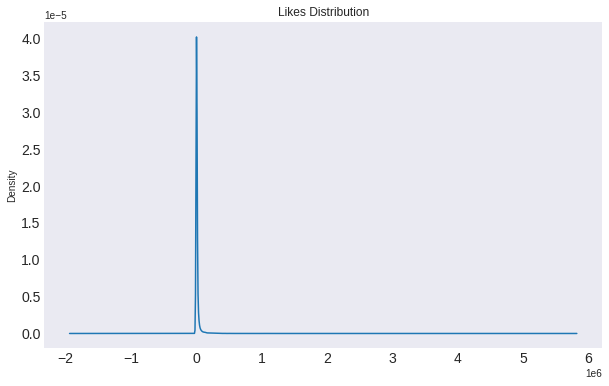

In [13]:
_ = train[TARGET_COL].plot(kind = 'density', title = 'Likes Distribution', fontsize=14, figsize=(10, 6))

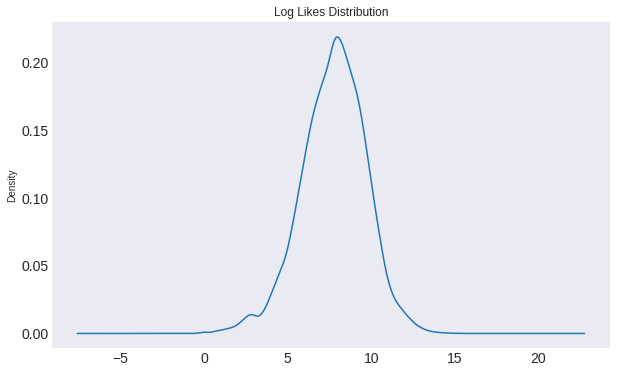

In [14]:
_ = pd.Series(np.log1p(train[TARGET_COL])).plot(kind = 'density', title = 'Log Likes Distribution', fontsize=14, figsize=(10, 6))

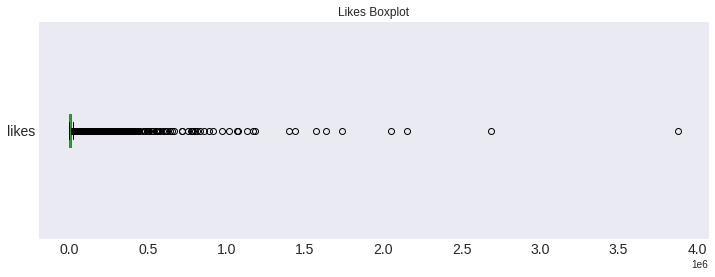

In [15]:
_ = train[TARGET_COL].plot(kind = 'box', vert=False, figsize=(12, 4), title = 'Likes Boxplot', fontsize=14)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26061 entries, 0 to 26060
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   video_id       26061 non-null  int64  
 1   title          26061 non-null  object 
 2   channel_title  26061 non-null  object 
 3   category_id    26061 non-null  float64
 4   publish_date   26061 non-null  object 
 5   tags           26061 non-null  object 
 6   views          26061 non-null  float64
 7   dislikes       26061 non-null  float64
 8   comment_count  26061 non-null  float64
 9   description    26061 non-null  object 
 10  country_code   26061 non-null  object 
 11  likes          26061 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 2.4+ MB


In [17]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

likes            0.0
country_code     0.0
description      0.0
comment_count    0.0
dislikes         0.0
views            0.0
tags             0.0
publish_date     0.0
category_id      0.0
channel_title    0.0
title            0.0
video_id         0.0
dtype: float64

In [18]:
train.nunique()

video_id         26061
title            26005
channel_title     5764
category_id         17
publish_date       348
tags             21462
views            25338
dislikes          2633
comment_count     4993
description      23426
country_code         4
likes            12134
dtype: int64

In [19]:
num_cols = ['views', 'dislikes', 'comment_count']

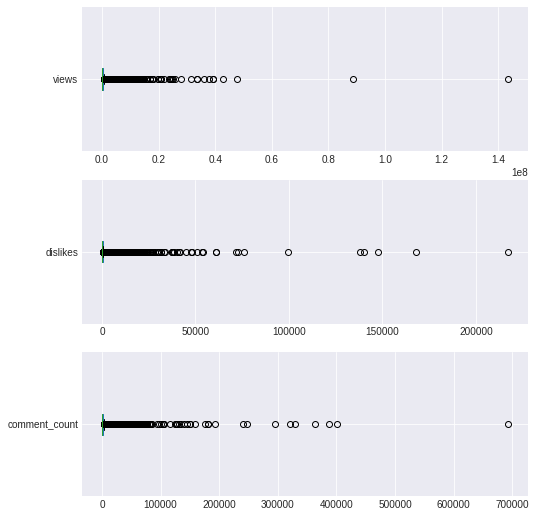

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(8, 9))
for i, c in enumerate(num_cols):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)

In [21]:
for c in num_cols + ['likes']:
  train[c] = np.log1p(train[c]) 

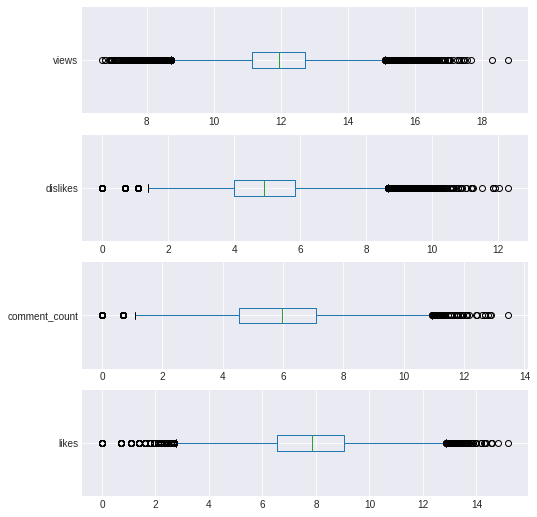

In [22]:
fig, axes = plt.subplots(4, 1, figsize=(8, 9))
for i, c in enumerate(num_cols + ['likes']):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)

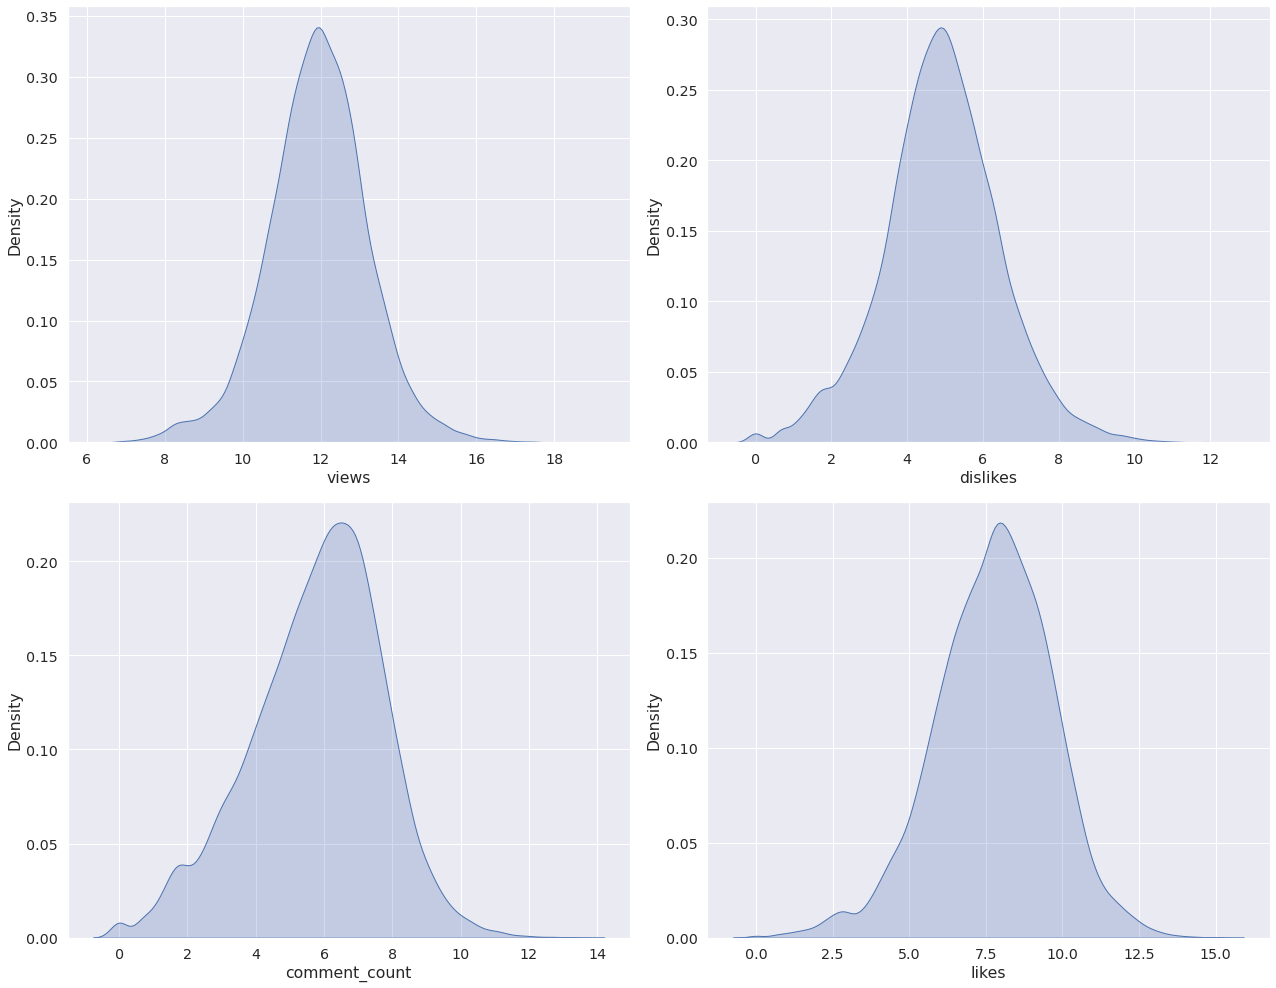

In [23]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols + ['likes']):
  plot = sns.kdeplot(data=train, x=c, ax=axes[i], fill=True)
plt.tight_layout()

<Figure size 1008x576 with 0 Axes>

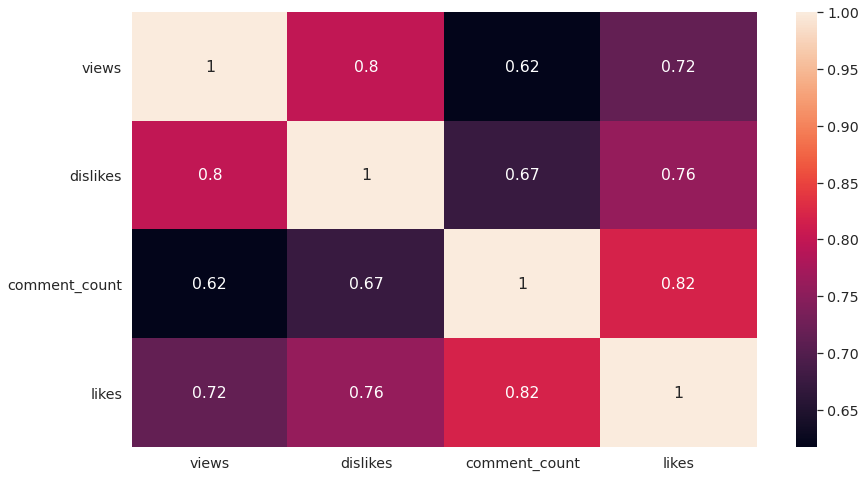

In [24]:
plt.figure(figsize=(14, 8))
_ = sns.heatmap(train[num_cols + ['likes']].corr(), annot=True)

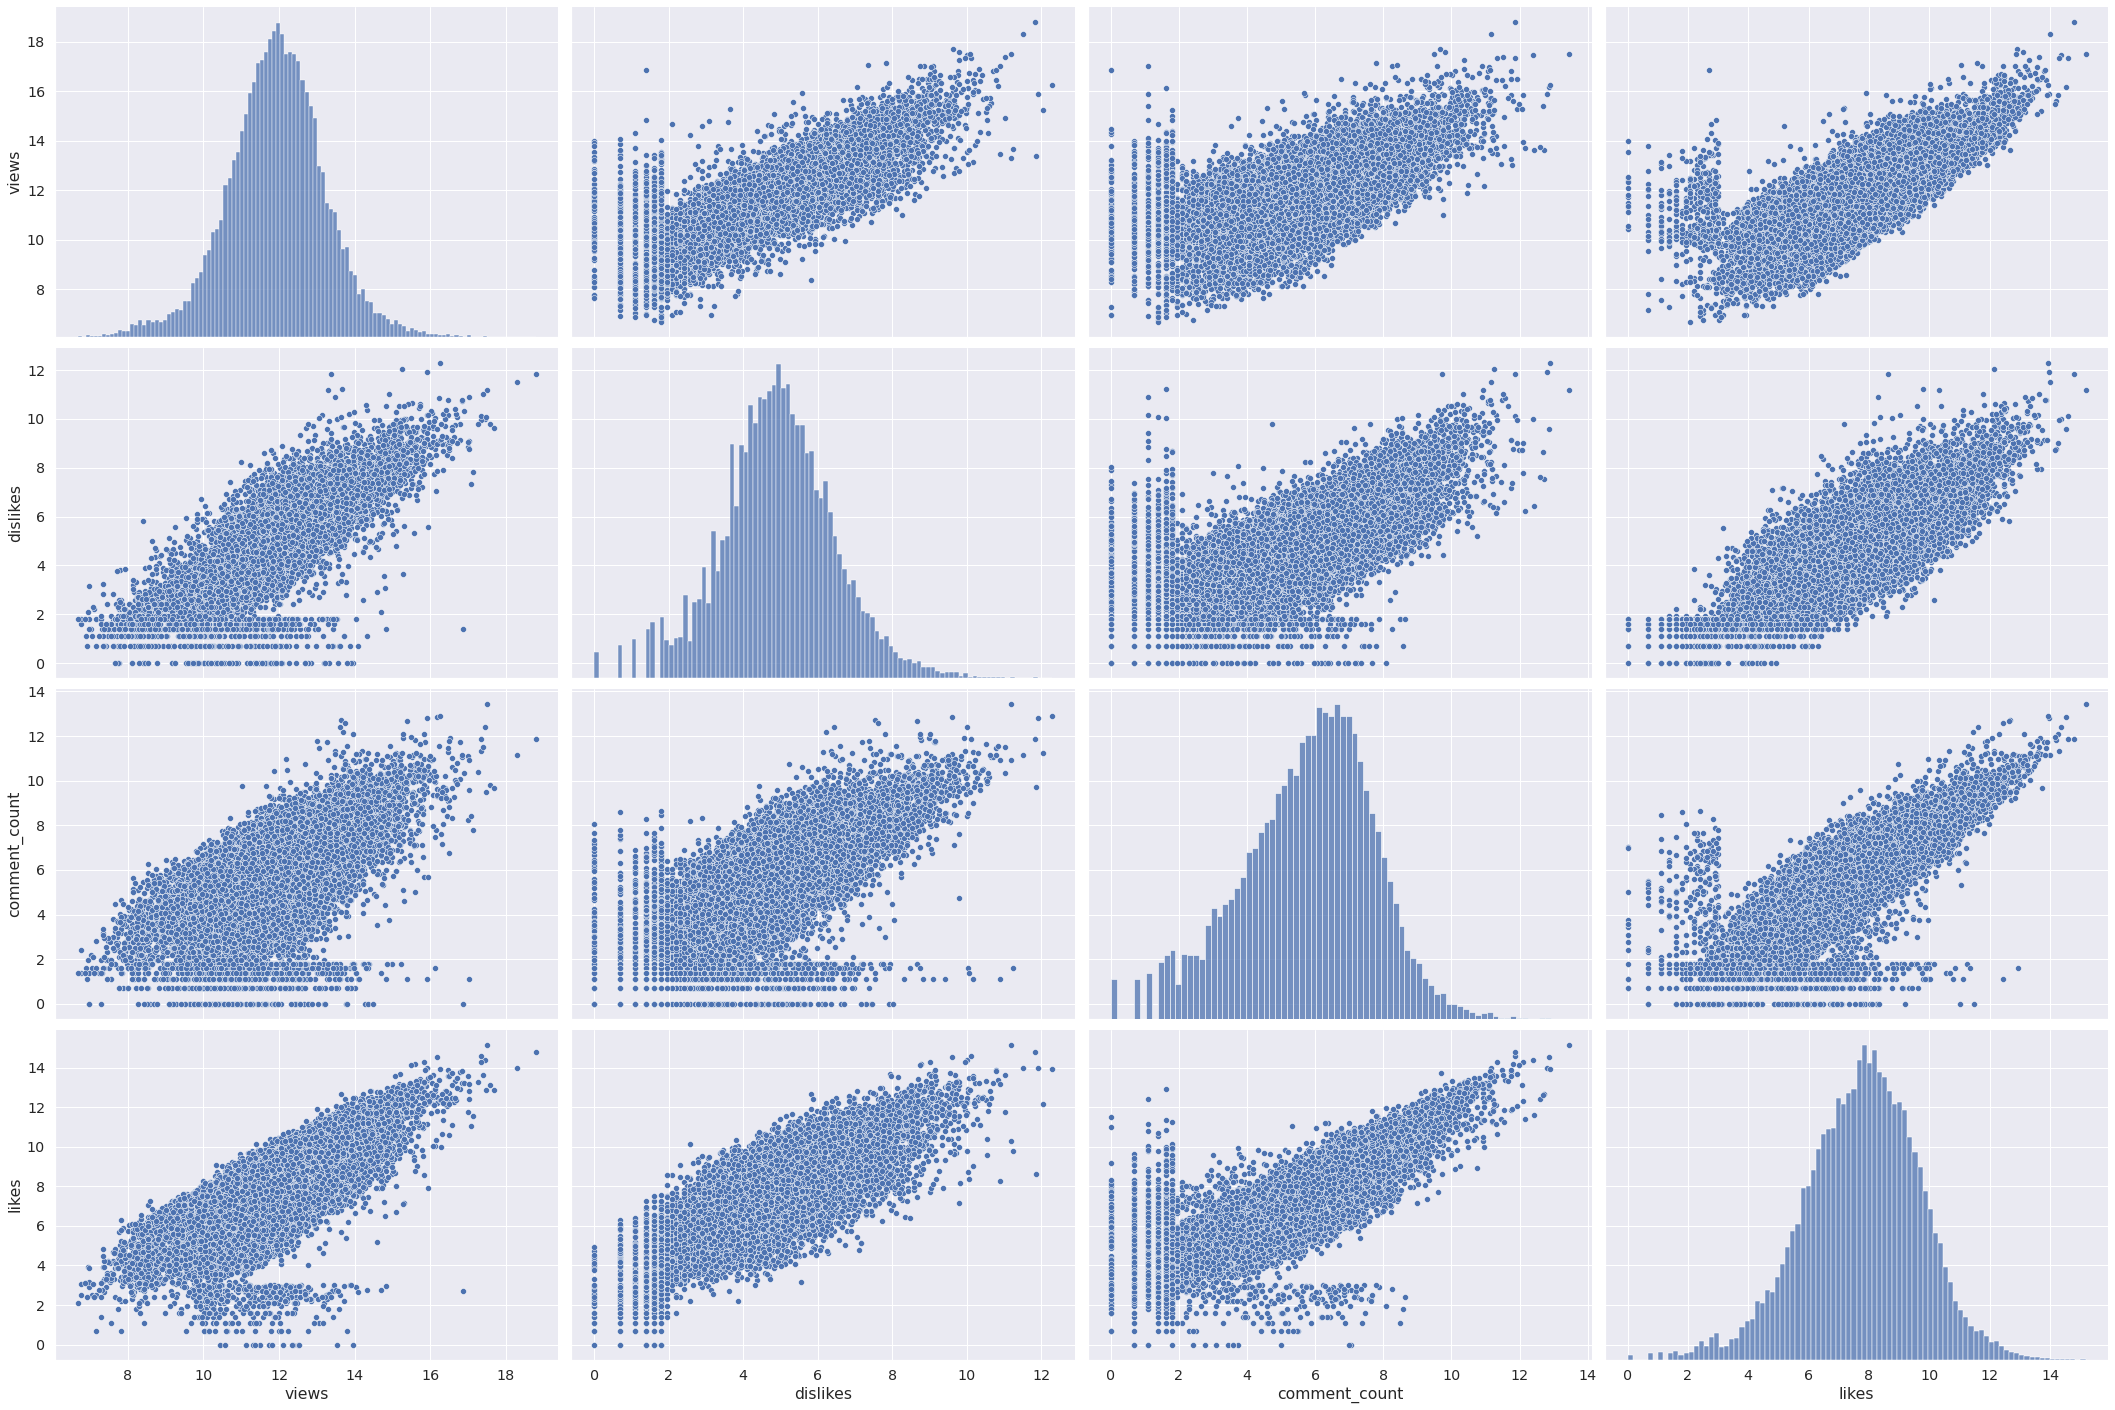

In [25]:
_ = sns.pairplot(train[num_cols + ['likes']], height=5, aspect=24/16)

In [26]:
train['channel_title'].nunique()

5764

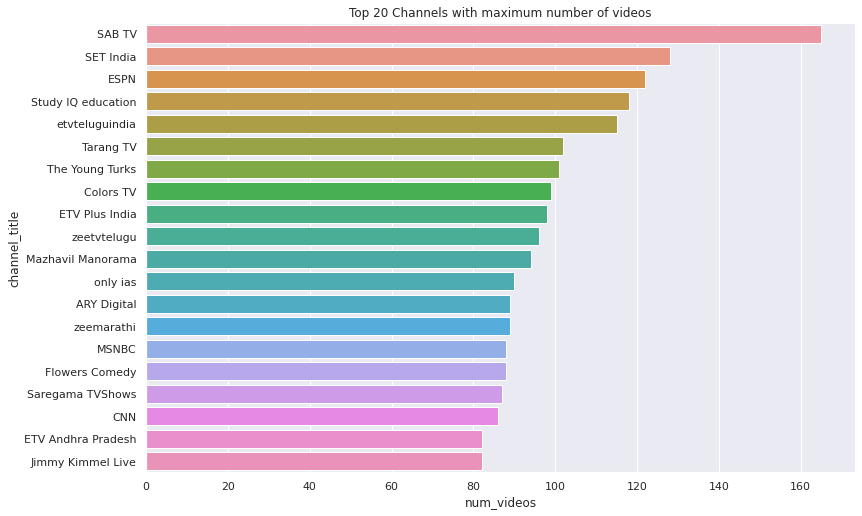

In [27]:
sns.set(rc={'figure.figsize':(12.7, 8.27)})

top_20_channels = train['channel_title'].value_counts()[:20].reset_index()
top_20_channels.columns = ['channel_title', 'num_videos']

_ = sns.barplot(data = top_20_channels, y = 'channel_title', x = 'num_videos')
_ = plt.title("Top 20 Channels with maximum number of videos")

In [28]:
country_wise_channels = train.groupby(['country_code', 'channel_title']).size().reset_index()
country_wise_channels.columns = ['country_code', 'channel_title', 'num_videos']
country_wise_channels = country_wise_channels.sort_values(by = 'num_videos', ascending=False)

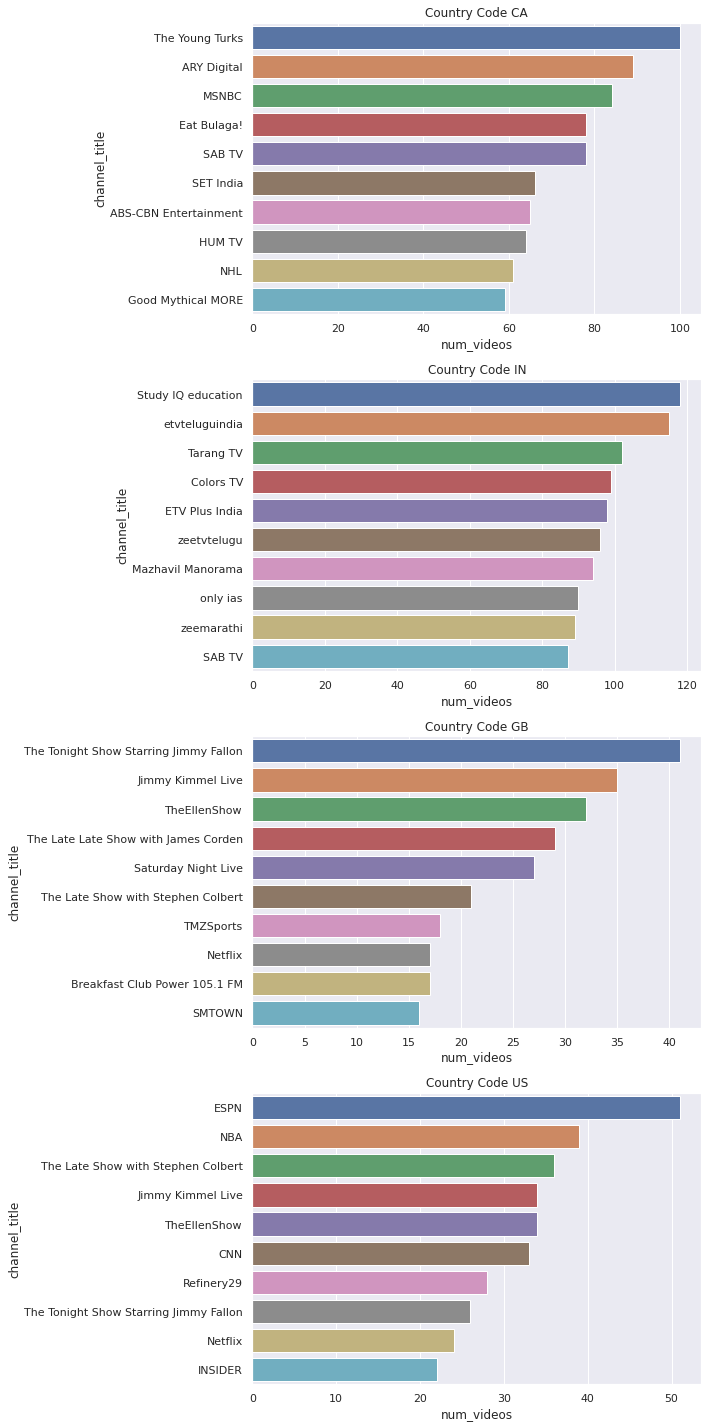

In [29]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

for i, c in enumerate(train['country_code'].unique()):
  country = country_wise_channels[country_wise_channels['country_code'] == c][:10]
  _ = sns.barplot(x = 'num_videos', y = 'channel_title', data = country, ax = axes[i])
  _ = axes[i].set_title(f'Country Code {c}')

plt.tight_layout()

In [30]:
country_wise_channels = train.groupby(['country_code', 'channel_title'])['likes'].max().reset_index()
country_wise_channels = country_wise_channels.sort_values(by = ['likes'], ascending=False)

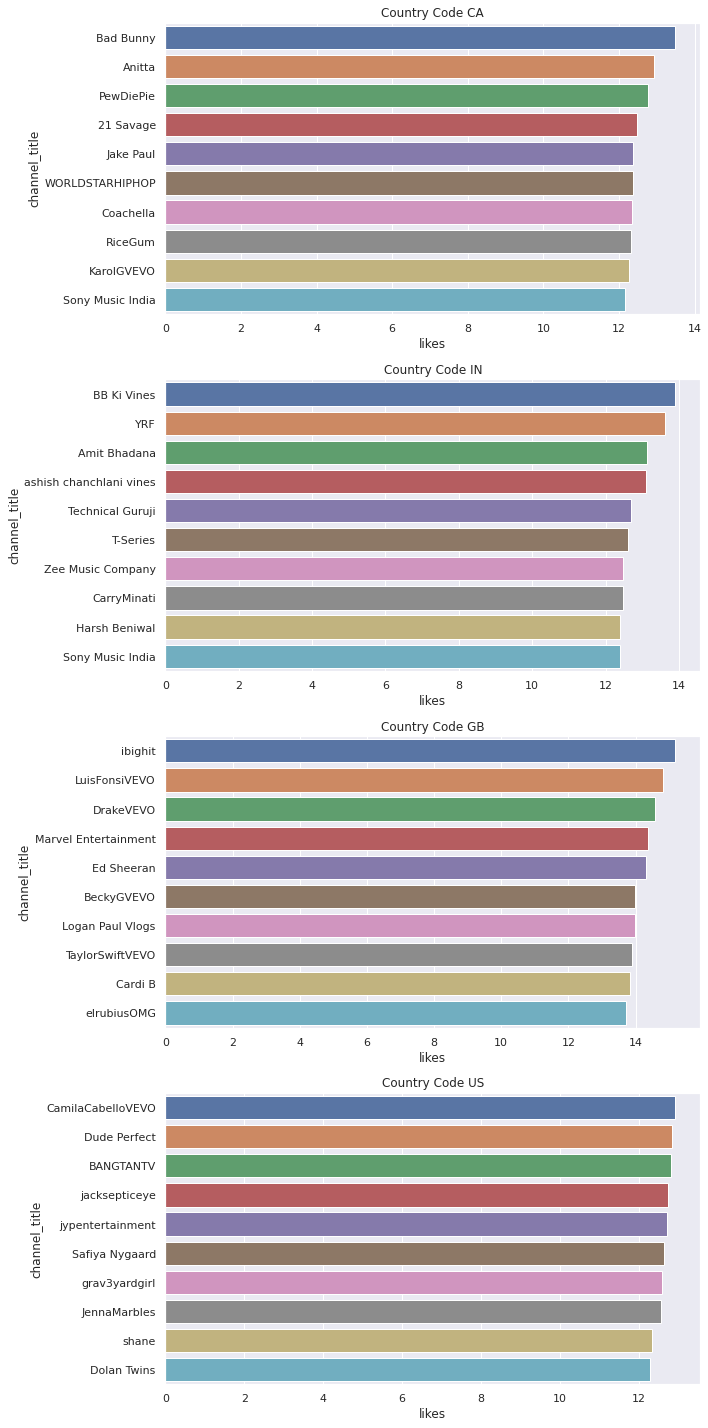

In [31]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

for i, c in enumerate(train['country_code'].unique()):
  country = country_wise_channels[country_wise_channels['country_code'] == c][:10]
  _ = sns.barplot(x = 'likes', y = 'channel_title', data = country, ax = axes[i])
  _ = axes[i].set_title(f'Country Code {c}')

plt.tight_layout()

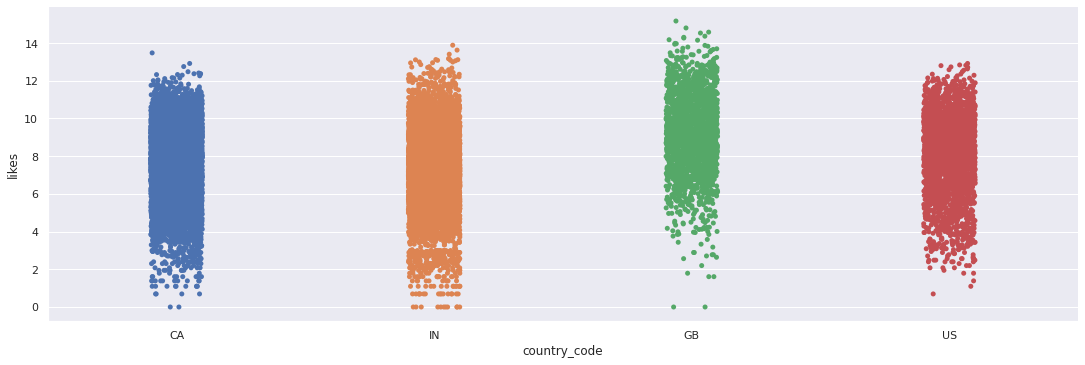

In [32]:
_ = sns.catplot(x="country_code", y="likes", data=train, height=5, aspect=24/8)

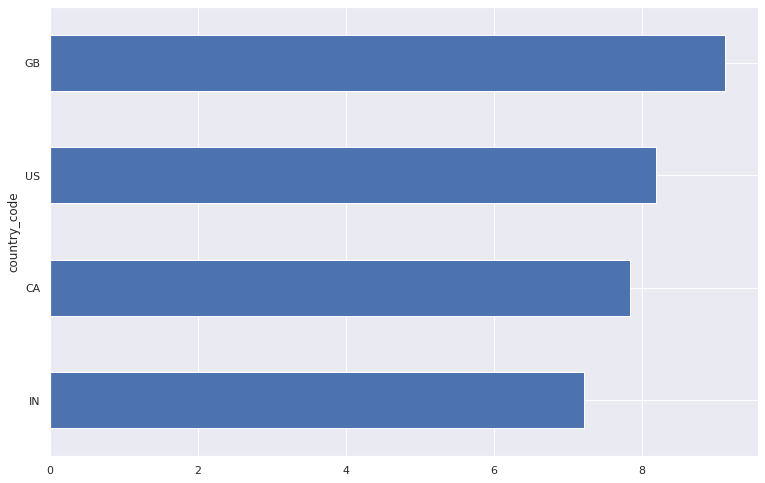

In [33]:
_ = train.groupby('country_code')['likes'].mean().sort_values().plot(kind = 'barh')

In [34]:
train['publish_date'] = pd.to_datetime(train['publish_date'], format='%Y-%m-%d')
test['publish_date'] = pd.to_datetime(test['publish_date'], format='%Y-%m-%d')
train['publish_date']

0       2017-12-12
1       2018-03-08
2       2018-03-26
3       2018-02-21
4       2018-05-10
           ...    
26056   2018-01-16
26057   2017-12-17
26058   2018-03-04
26059   2018-05-17
26060   2018-01-16
Name: publish_date, Length: 26061, dtype: datetime64[ns]

In [35]:
train['publish_date'].min(), train['publish_date'].max()

(Timestamp('2006-07-23 00:00:00'), Timestamp('2018-06-14 00:00:00'))

In [36]:
train['publish_date'].dt.year.value_counts()

2018    18841
2017     7132
2015       16
2016       16
2011       13
2014        9
2013        9
2009        8
2012        6
2010        4
2008        3
2007        3
2006        1
Name: publish_date, dtype: int64

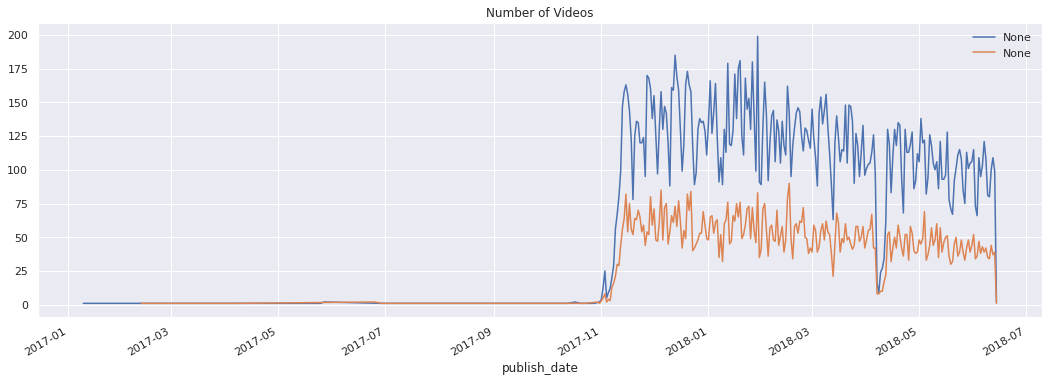

In [37]:
latest_data_train = train[train['publish_date'] > '2017']
latest_data_test = test[test['publish_date'] > '2017']
_ = latest_data_train.sort_values(by = 'publish_date').groupby('publish_date').size().plot(figsize=(18, 6),title = 'Number of Videos')
_ = latest_data_test.sort_values(by = 'publish_date').groupby('publish_date').size().plot(figsize=(18, 6),title = 'Number of Videos')
_ = plt.legend()

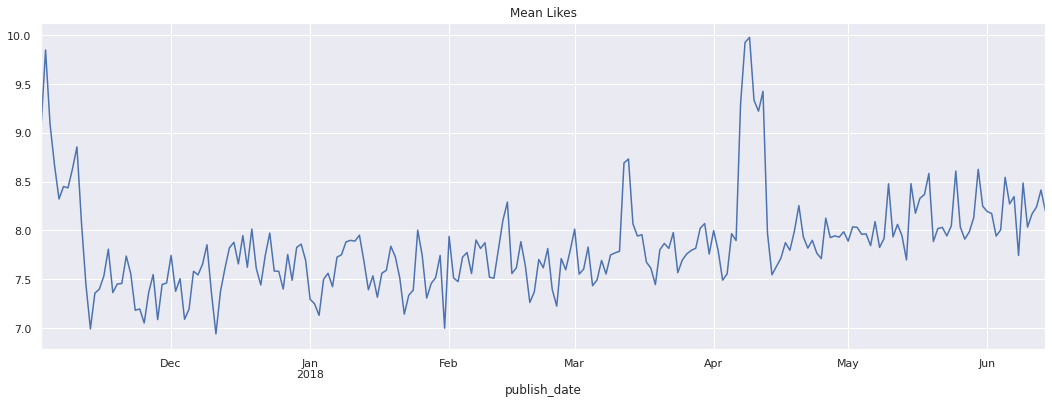

In [38]:
latest_data = train[train['publish_date'] > '2017-11']
_ = latest_data.sort_values(by = 'publish_date').groupby('publish_date')['likes'].mean().plot(figsize=(18, 6), title="Mean Likes")

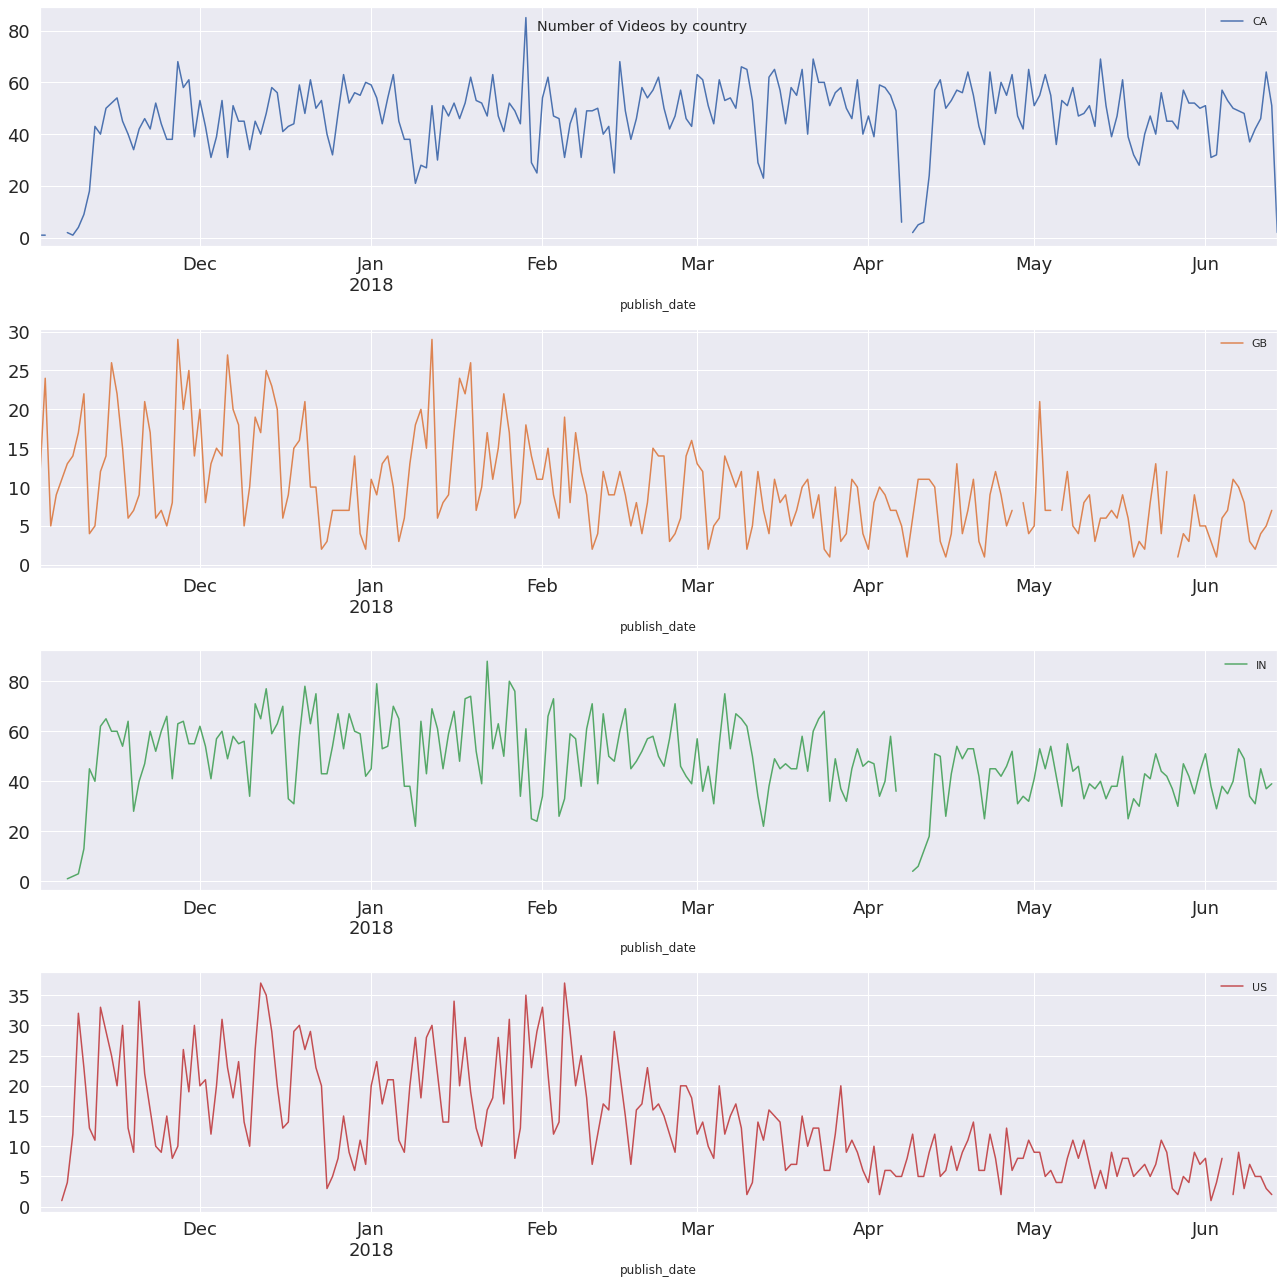

In [39]:
tmp = latest_data.groupby(['publish_date', 'country_code']).size().reset_index()
_ = tmp.pivot_table(index = 'publish_date', columns = 'country_code', values=0).plot(subplots=True, figsize=(18, 18),
                                                                                           title='Number of Videos by country',
                                                                                           sharex=False,
                                                                                           fontsize=18)
plt.tight_layout()

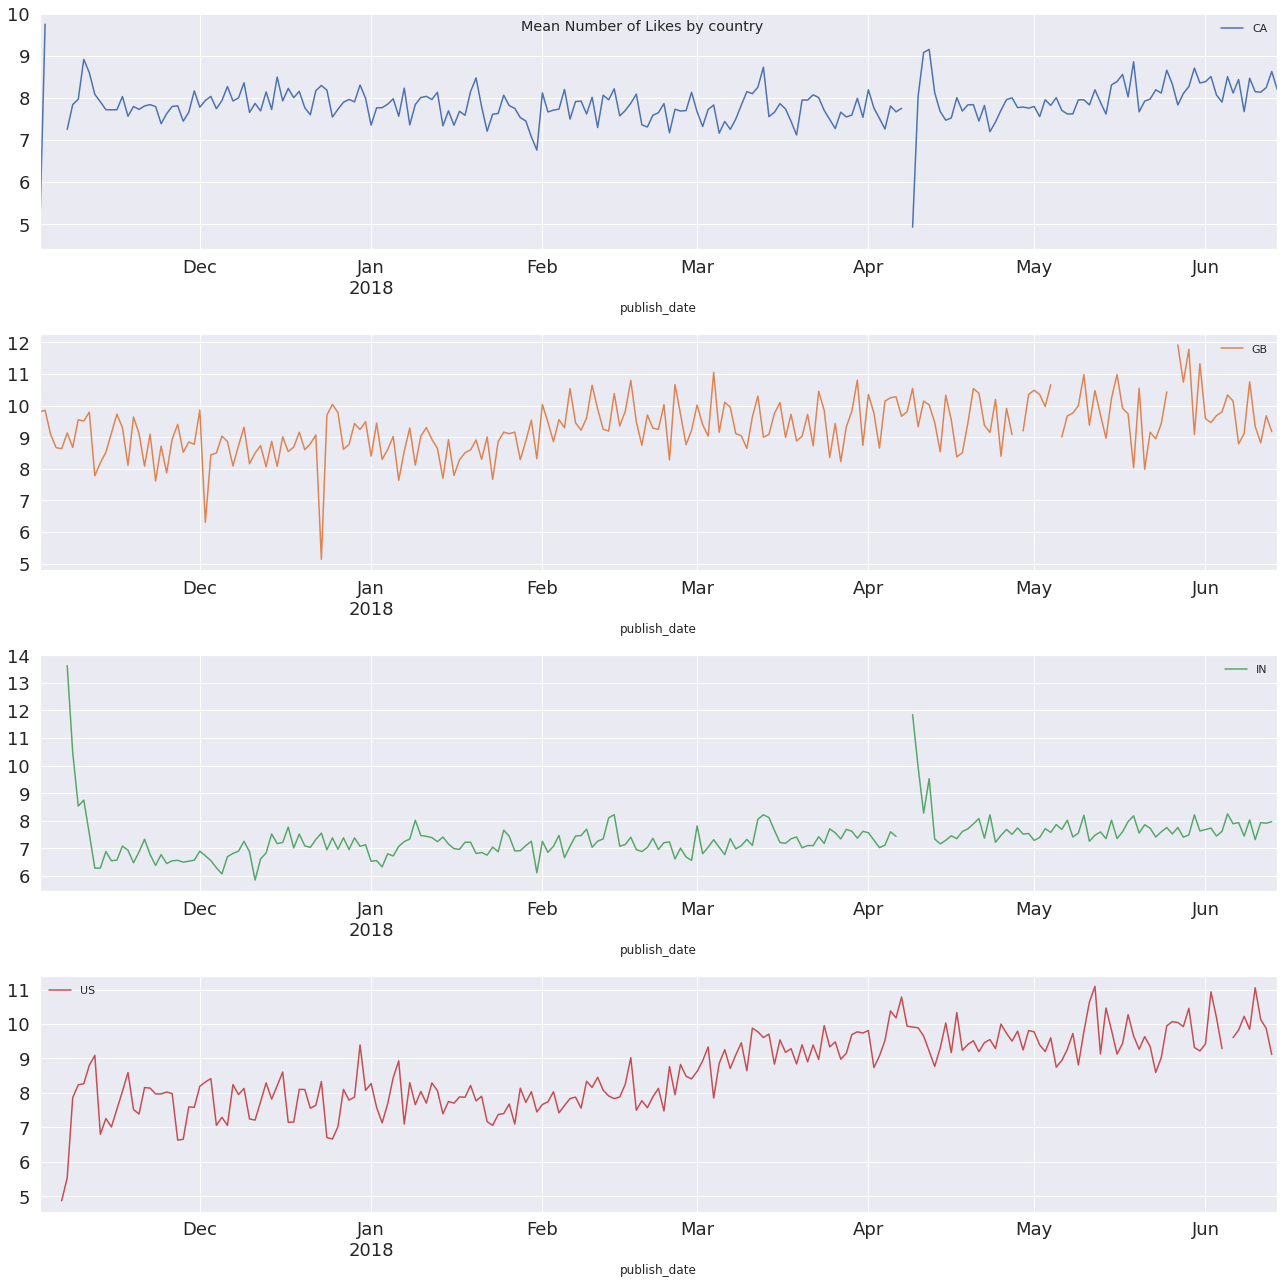

In [40]:
tmp = latest_data.groupby(['publish_date', 'country_code'])['likes'].mean().reset_index()
_ = tmp.pivot_table(index = 'publish_date', columns = 'country_code', values='likes').plot(subplots=True, figsize=(18, 18),
                                                                                           title='Mean Number of Likes by country',
                                                                                           sharex=False,
                                                                                           fontsize=18)
plt.tight_layout()

In [41]:
train['dayofweek'] = train['publish_date'].dt.dayofweek

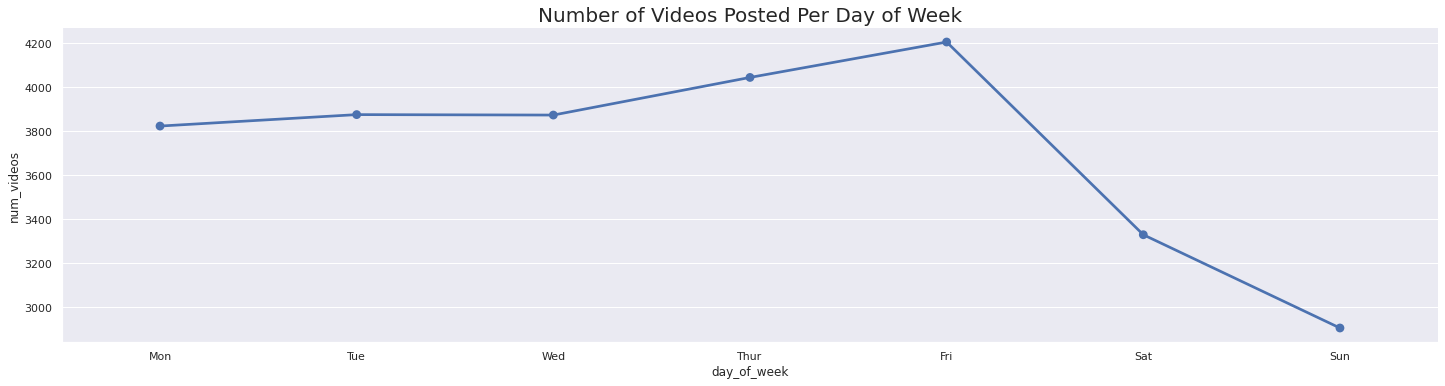

In [42]:
n_videos_per_day_of_week = train['dayofweek'].value_counts().sort_index().reset_index()
n_videos_per_day_of_week.columns = ['day_of_week', 'num_videos']
n_videos_per_day_of_week['day_of_week'] = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
_ = sns.catplot(x = 'day_of_week', y = 'num_videos', data = n_videos_per_day_of_week, kind = 'point',aspect = 24/6)
_ = plt.title("Number of Videos Posted Per Day of Week", fontsize=20)

In [43]:
text_cols = ['title', 'tags', 'description']

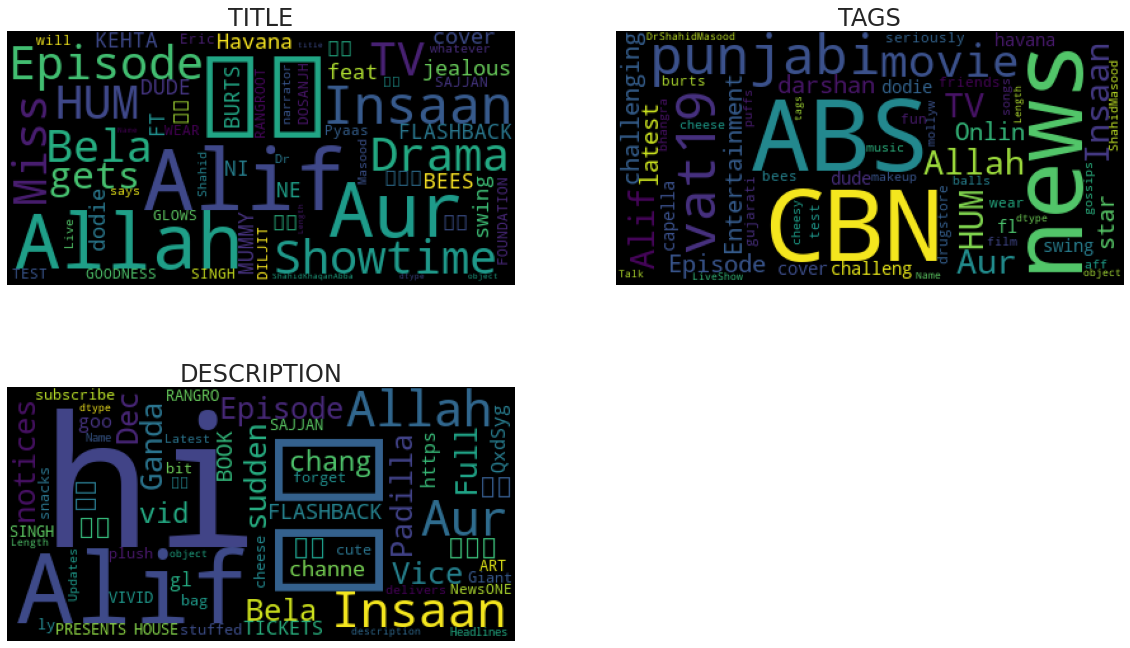

In [44]:
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(stopwords = set(list(STOPWORDS) + ['|']), random_state = 42)
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(text_cols):
  op = wc.generate(str(train[c]))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(c.upper(), fontsize=24)
  _ = axes[i].axis('off')

_ = fig.delaxes(axes[3])

In [45]:
train['likes'].describe()

count    26061.000000
mean         7.739954
std          1.927899
min          0.000000
25%          6.527958
50%          7.840706
75%          9.054154
max         15.171369
Name: likes, dtype: float64

In [46]:
100 * ((train['likes'] > 10).sum()/train.shape[0])

10.694140669966616

In [47]:
def plot_countrywise(country_code = 'IN'):
  country = train[train['country_code'] == country_code]
  country = country[country['likes'] > 10]
  fig, axes = plt.subplots(2, 2, figsize=(20, 12))
  axes = [ax for axes_row in axes for ax in axes_row]

  for i, c in enumerate(text_cols):
    op = wc.generate(str(country[c]))
    _ = axes[i].imshow(op)
    _ = axes[i].set_title(c.upper(), fontsize=24)
    _ = axes[i].axis('off')

  fig.delaxes(axes[3])
  _ = plt.suptitle(f"Country Code: '{country_code}'", fontsize=30)

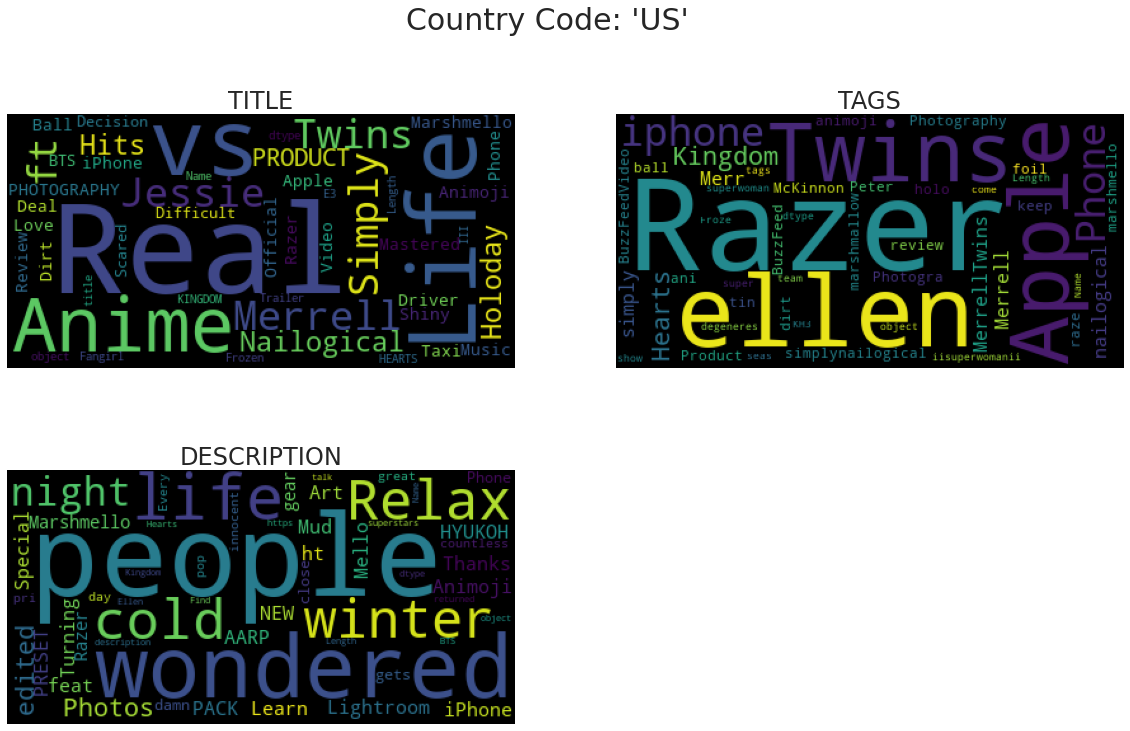

In [48]:
plot_countrywise("US")

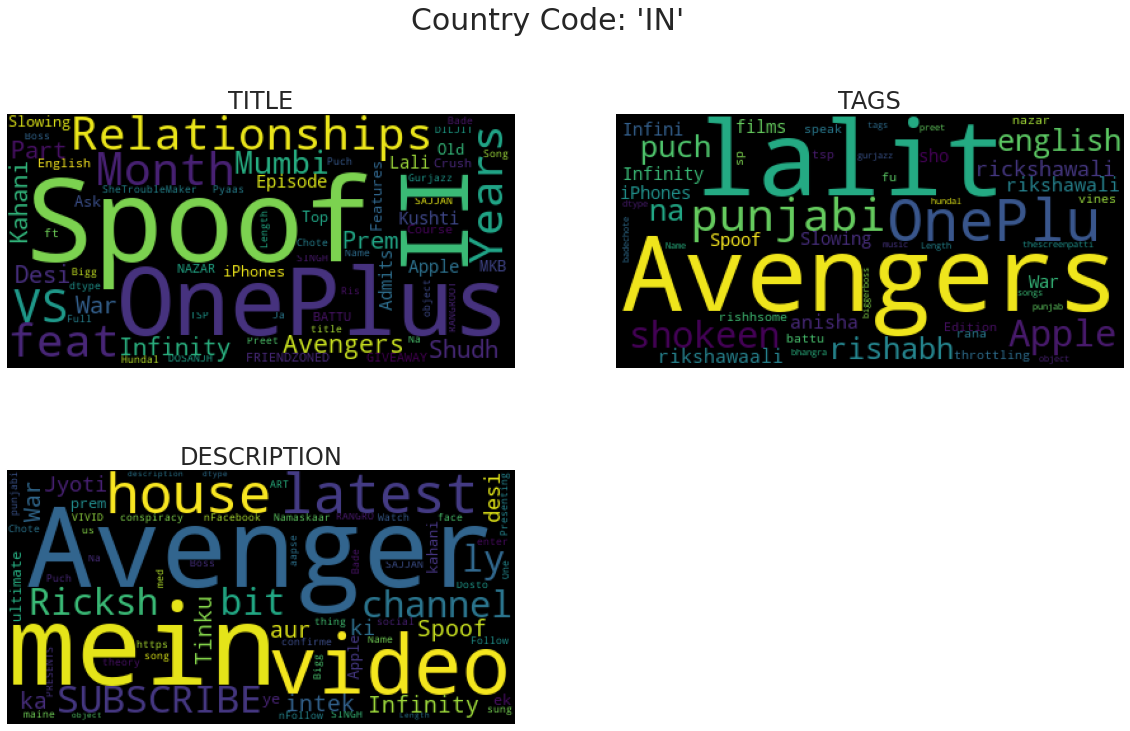

In [49]:
plot_countrywise("IN")

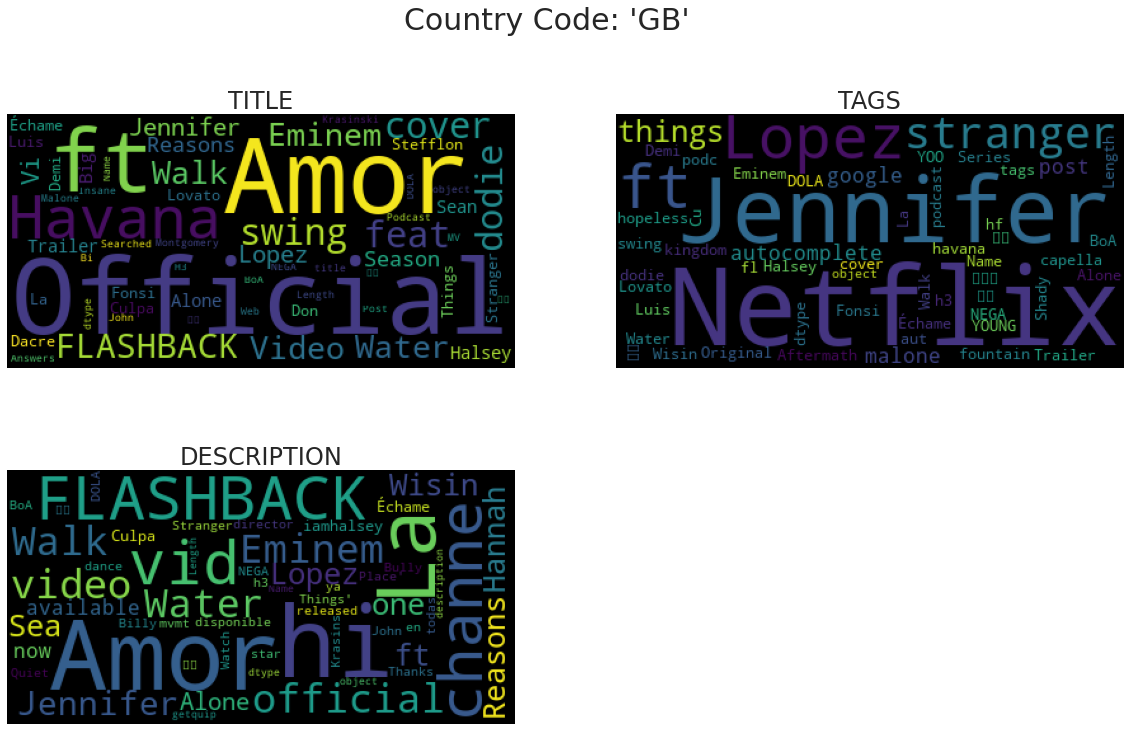

In [50]:
plot_countrywise("GB")

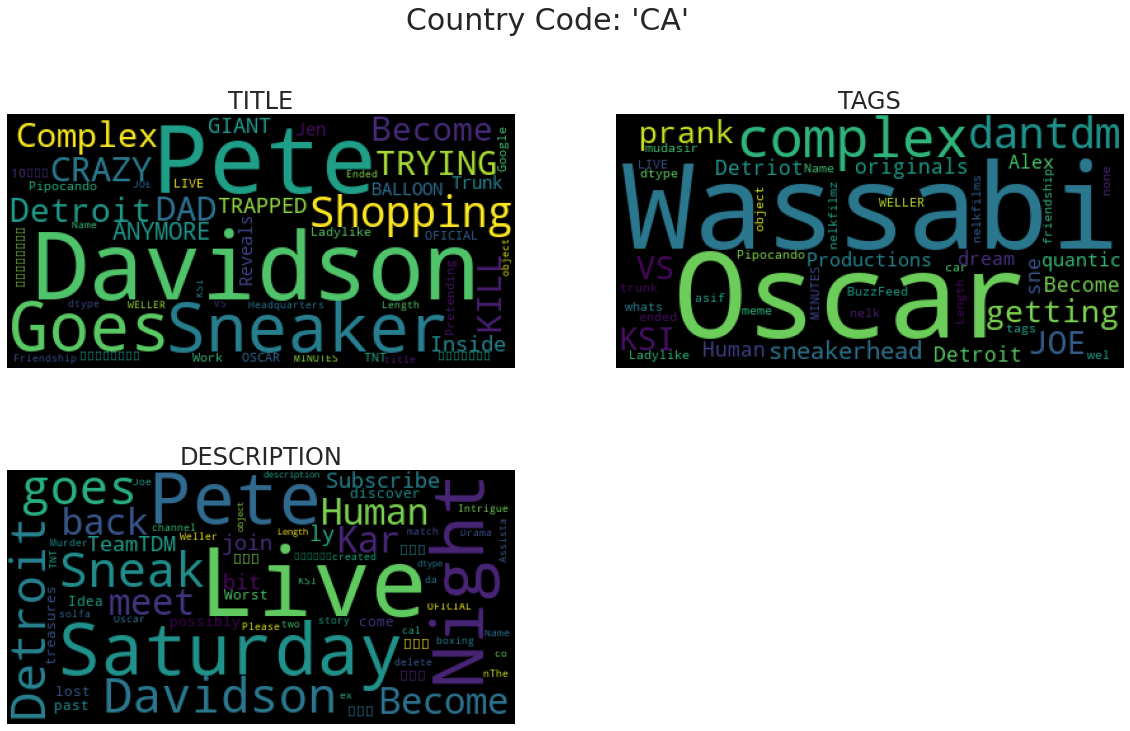

In [48]:
plot_countrywise("CA")

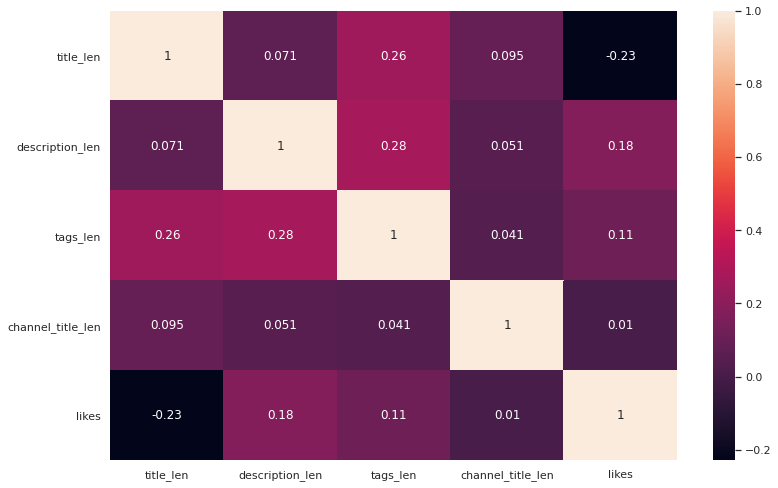

In [51]:
train['title_len'] = train['title'].apply(lambda x: len(x))
train['description_len'] = train['description'].apply(lambda x: len(x))
train['tags_len'] = train['tags'].apply(lambda x: len(x))
train['channel_title_len'] = train['channel_title'].apply(lambda x: len(x))

_  = sns.heatmap(train[['title_len', 'description_len', 'tags_len', 'channel_title_len', 'likes']].corr(), annot = True)

In [52]:
def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COL] = preds_test

  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  from google.colab import files
  files.download(file_name)

In [53]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train[num_cols + ['likes']] = train[num_cols + ['likes']].apply(lambda x: np.log1p(x))
test[num_cols] = test[num_cols].apply(lambda x: np.log1p(x))

In [54]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def rmsle(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

def av_metric(y_true, y_pred):
  return 1000 * np.sqrt(mean_squared_error(y_true, y_pred))

target = train[TARGET_COL]

In [55]:
preds_target = pd.Series([target.median()] * len(train))

av_metric_score = av_metric(target, preds_target)

print(f'AV metric score is: {av_metric_score}')

AV metric score is: 1930.4927341163989


In [ ]:
preds_test = pd.Series([target.median()] * len(test))
preds_test = np.expm1(preds_test)
download_preds(preds_test, 'hacklive2_median_preds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
likes_per_view = ((train['likes'] + 1)/(train['views'] + 1))
likes_per_view.mean()

0.6723608458619709

In [57]:
preds_target = train['views'] * 0.677

av_metric_score = av_metric(target, preds_target)

print(f'AV metric score is: {av_metric_score}')

AV metric score is: 1473.9157749667168


In [ ]:
preds_test = test['views'] * 0.672
preds_test = np.expm1(preds_test)
download_preds(preds_test, 'hacklive2_preds_using_views.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
ss = pd.read_csv('SS.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [59]:
ID_COL, TARGET_COL = 'video_id', 'likes'

num_cols = ['views', 'dislikes', 'comment_count']
cat_cols = ['category_id', 'country_code']
text_cols = ['title', 'channel_title', 'tags', 'description']
date_cols = ['publish_date']

In [60]:
train.shape, test.shape

((26061, 12), (11170, 11))

In [61]:
df = pd.concat([train, test], axis=0).reset_index(drop = True)
df.shape

(37231, 12)

In [62]:
df.head(3)

video_id  ...   likes
0     53364  ...  2351.0
1     51040  ...  3264.0
2      1856  ...   580.0

[3 rows x 12 columns]

In [63]:
df = pd.get_dummies(df, columns = cat_cols)

In [64]:
df = df.fillna(-999)
df.isnull().sum().sum()

0

In [65]:
df[num_cols + ['likes']] = df[num_cols + ['likes']].apply(lambda x: np.log1p(x))

In [66]:
df['likes']

0         7.763021
1         8.091015
2         6.364751
3        11.323869
4         8.176954
           ...    
37226          NaN
37227          NaN
37228          NaN
37229          NaN
37230          NaN
Name: likes, Length: 37231, dtype: float64

In [67]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in train_proc.columns if c not in [ID_COL, TARGET_COL]]

In [68]:
trn, val = train_test_split(train_proc, test_size=0.2, random_state = 1)

###### Input to our model will be the features
X_trn, X_val = trn[features], val[features]

###### Output of our model will be the TARGET_COL
y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

##### Features for the test data that we will be predicting
X_test = test_proc[features]

In [69]:

from sklearn.metrics import mean_squared_error, mean_squared_log_error

def rmsle(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

def av_metric(y_true, y_pred):
  return 1000 * np.sqrt(mean_squared_error(y_true, y_pred))

In [70]:
clf = LinearRegression()

_ = clf.fit(X_trn[num_cols], y_trn)

preds_val = clf.predict(X_val[num_cols])

av_metric_score = av_metric(y_val, preds_val)

print(f'AV metric score is: {av_metric_score}')

AV metric score is: 949.5701548787257


In [ ]:
preds_test = clf.predict(X_test[num_cols])

preds_test = np.expm1(preds_test)

download_preds(preds_test, 'lr.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
X_trn.columns

Index(['title', 'channel_title', 'publish_date', 'tags', 'views', 'dislikes',
       'comment_count', 'description', 'category_id_1.0', 'category_id_2.0',
       'category_id_10.0', 'category_id_15.0', 'category_id_17.0',
       'category_id_19.0', 'category_id_20.0', 'category_id_22.0',
       'category_id_23.0', 'category_id_24.0', 'category_id_25.0',
       'category_id_26.0', 'category_id_27.0', 'category_id_28.0',
       'category_id_29.0', 'category_id_30.0', 'category_id_43.0',
       'country_code_CA', 'country_code_GB', 'country_code_IN',
       'country_code_US'],
      dtype='object')

In [72]:
features = [c for c in X_trn.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in text_cols + date_cols]

In [73]:
clf = LinearRegression()

_ = clf.fit(X_trn[cat_num_cols], y_trn)

preds_val = clf.predict(X_val[cat_num_cols])

av_metric_score = av_metric(y_val, preds_val)

print(f'AV metric score is: {av_metric_score}')

AV metric score is: 873.0627392234118


In [ ]:
preds_test = clf.predict(X_test[cat_num_cols])

preds_test = np.expm1(preds_test)

download_preds(preds_test, 'lr_num_cat.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
clf = DecisionTreeRegressor(random_state=2)

_ = clf.fit(X_trn[cat_num_cols], y_trn)

preds_val = clf.predict(X_val[cat_num_cols])

av_metric_score = av_metric(y_val, preds_val)

print(f'AV metric score is: {av_metric_score}')

AV metric score is: 929.8019826197176


In [ ]:


from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
}

clf = RandomizedSearchCV(DecisionTreeRegressor(),
                         hyperparam_combs,
                         scoring='neg_root_mean_squared_error',
                         random_state=1,
                         n_iter=20)

search = clf.fit(train_proc[cat_num_cols], train_proc[TARGET_COL])

search.best_params_

{'max_depth': 12,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'min_samples_split': 2}

In [75]:
best_params = {'max_depth': 12,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'random_state': 1,
 'min_samples_split': 2}

clf = DecisionTreeRegressor(**best_params)

_ = clf.fit(X_trn[cat_num_cols], y_trn)

preds_val = clf.predict(X_val[cat_num_cols])

av_metric_score = av_metric(y_val, preds_val)

print(f'AV metric score is: {av_metric_score}')

AV metric score is: 766.018775496316


In [ ]:
preds_test = clf.predict(X_test[cat_num_cols])

preds_test = np.expm1(preds_test)

download_preds(preds_test, 'dt_num_cat.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
def run_clf_kfold(clf, train, test, features):

  N_SPLITS = 5

  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)


    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn, y_trn)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metric(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metric(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  return oofs, preds

In [79]:
dt_params = {'max_depth': 12,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'min_samples_split': 2}

clf = DecisionTreeRegressor(**dt_params)
        

dt_oofs, dt_preds = run_clf_kfold(clf, train_proc, test_proc, cat_num_cols)


------------- Fold 1 -------------

AV metric score for validation set is 775.563060992375

------------- Fold 2 -------------

AV metric score for validation set is 762.0429396193739

------------- Fold 3 -------------

AV metric score for validation set is 765.5829545666472

------------- Fold 4 -------------

AV metric score for validation set is 762.2692193088232

------------- Fold 5 -------------

AV metric score for validation set is 769.1957813995168


AV metric for oofs is 766.9476939532396


In [78]:
clf = LGBMRegressor()
lgb_oofs, lgb_preds = run_clf_kfold(clf, train_proc, test_proc, cat_num_cols)


------------- Fold 1 -------------

AV metric score for validation set is 674.7737515393275

------------- Fold 2 -------------

AV metric score for validation set is 678.3212622895253

------------- Fold 3 -------------

AV metric score for validation set is 669.5119539218649

------------- Fold 4 -------------

AV metric score for validation set is 665.6236530707358

------------- Fold 5 -------------

AV metric score for validation set is 671.8950668383243


AV metric for oofs is 672.0393057033824


In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_5_folds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(train_proc))
  preds = np.zeros((len(test_proc)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  feature_importances = pd.DataFrame()

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metric(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metric(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  feature_importances = feature_importances.reset_index(drop = True)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
  fi.plot(kind = 'barh', figsize=(12, 6))

  return oofs, preds, fi


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's rmse: 0.791135
[400]	valid_0's rmse: 0.699574
[600]	valid_0's rmse: 0.684465
[800]	valid_0's rmse: 0.677655
[1000]	valid_0's rmse: 0.674184
[1200]	valid_0's rmse: 0.671939
[1400]	valid_0's rmse: 0.670195
[1600]	valid_0's rmse: 0.669074
[1800]	valid_0's rmse: 0.668281
[2000]	valid_0's rmse: 0.667496
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 0.667496

AV metric score for validation set is 667.4962192566917

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's rmse: 0.790864
[400]	valid_0's rmse: 0.700985
[600]	valid_0's rmse: 0.687805
[800]	valid_0's rmse: 0.682057
[1000]	valid_0's rmse: 0.678589
[1200]	valid_0's rmse: 0.676595
[1400]	valid_0's rmse: 0.675418
[1600]	valid_0's rmse: 0.674597
[1800]	valid_0's rmse: 0.673857
[2000]	valid_0's rmse: 0.6736
Did not meet early stopping. Best i

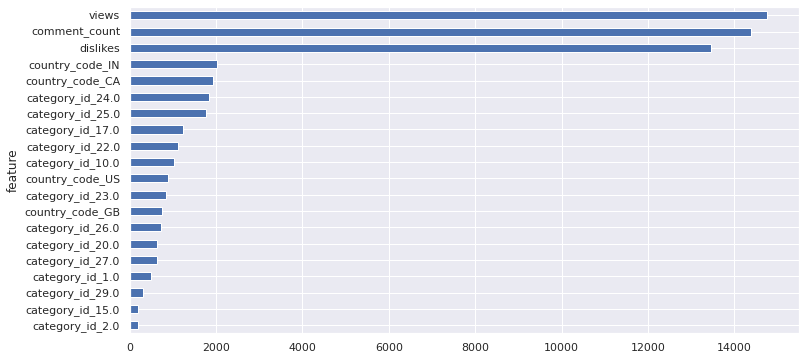

In [81]:
clf = LGBMRegressor(n_estimators = 2000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.76,
                        metric = 'None',
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_5_folds_tuned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


------------- Fold 1 -------------
0:	learn: 1.9161623	test: 1.9077476	best: 1.9077476 (0)	total: 54.2ms	remaining: 2m 42s
200:	learn: 0.8395688	test: 0.8496237	best: 0.8496237 (200)	total: 1.2s	remaining: 16.7s
400:	learn: 0.7310593	test: 0.7459856	best: 0.7459856 (400)	total: 2.33s	remaining: 15.1s
600:	learn: 0.7071283	test: 0.7225519	best: 0.7225519 (600)	total: 3.44s	remaining: 13.7s
800:	learn: 0.6931874	test: 0.7085013	best: 0.7085013 (800)	total: 4.56s	remaining: 12.5s
1000:	learn: 0.6828767	test: 0.6984767	best: 0.6984767 (1000)	total: 5.63s	remaining: 11.2s
1200:	learn: 0.6741208	test: 0.6901979	best: 0.6901979 (1200)	total: 6.72s	remaining: 10.1s
1400:	learn: 0.6664207	test: 0.6833039	best: 0.6833039 (1400)	total: 7.84s	remaining: 8.95s
1600:	learn: 0.6604077	test: 0.6785152	best: 0.6785152 (1600)	total: 8.94s	remaining: 7.81s
1800:	learn: 0.6554195	test: 0.6750037	best: 0.6750022 (1798)	total: 10.1s	remaining: 6.73s
2000:	learn: 0.6510266	test: 0.6720600	best: 0.6720600 (2

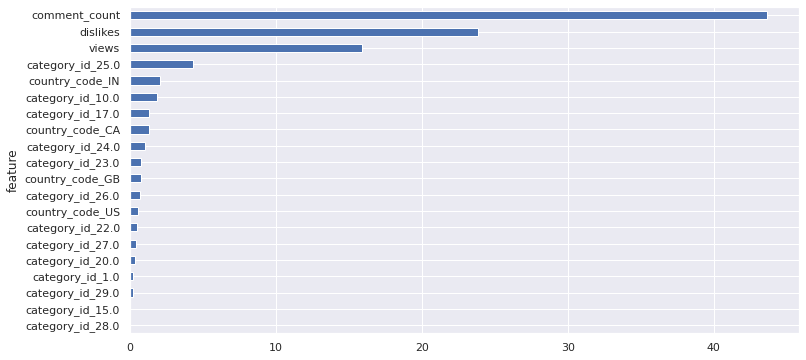

In [82]:
clf = CatBoostRegressor(n_estimators = 3000,
                       learning_rate = 0.01,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

cb_oofs, cb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [ ]:
cb_preds_t = np.expm1(cb_preds)
download_preds(cb_preds_t, file_name = 'hacklive_cb_folds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


------------- Fold 1 -------------
[16:00:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.43322
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:1.26613
[400]	validation_0-rmse:0.720884
[600]	validation_0-rmse:0.690156
[800]	validation_0-rmse:0.680919
[1000]	validation_0-rmse:0.676396
[1200]	validation_0-rmse:0.673498
[1400]	validation_0-rmse:0.671815
[1600]	validation_0-rmse:0.670359
[1800]	validation_0-rmse:0.669804
[1999]	validation_0-rmse:0.669047

AV metric score for validation set is 669.0429468719235

------------- Fold 2 -------------
[16:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.42073
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:1.26529
[400]	validation_0-rmse:0.728429
[600]	validation_0-rmse:0

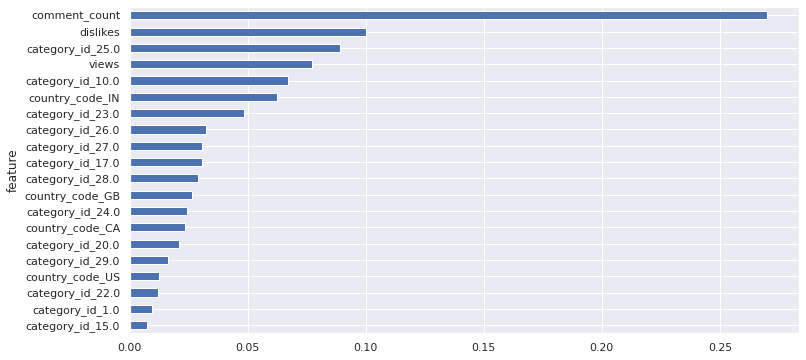

In [83]:
clf = XGBRegressor(n_estimators = 2000,
                    max_depth = 6,
                    learning_rate = 0.01,
                    colsample_bytree = 0.5,
                    random_state=1452,
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [ ]:
xgb_preds_t = np.expm1(xgb_preds)
download_preds(xgb_preds_t, file_name = 'hacklive_xgb_5_folds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
def join_df(train, test):

  df = pd.concat([train, test], axis=0).reset_index(drop = True)
  features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
  df[num_cols + ['likes']] = df[num_cols + ['likes']].apply(lambda x: np.log1p(x))

  return df, features

def split_df_and_get_features(df, train_nrows):

  train, test = df[:train_nrows].reset_index(drop = True), df[train_nrows:].reset_index(drop = True)
  features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
  
  return train, test, features

In [85]:
df, features = join_df(train, test)

In [86]:
cat_cols = ['category_id', 'country_code', 'channel_title']

In [87]:
### Label Encoding
df[cat_cols] = df[cat_cols].apply(lambda x: pd.factorize(x)[0])

In [88]:
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y-%m-%d')
df['publish_date_days_since_start'] = (df['publish_date'] - df['publish_date'].min()).dt.days

df['publish_date_day_of_week'] = df['publish_date'].dt.dayofweek
df['publish_date_year'] = df['publish_date'].dt.year
df['publish_date_month'] = df['publish_date'].dt.month

In [89]:
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]

In [90]:
cat_num_cols

['channel_title',
 'category_id',
 'views',
 'dislikes',
 'comment_count',
 'country_code',
 'publish_date_days_since_start',
 'publish_date_day_of_week',
 'publish_date_year',
 'publish_date_month']

In [91]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.632226
[600]	valid_0's rmse: 0.61216
[900]	valid_0's rmse: 0.603608
[1200]	valid_0's rmse: 0.598652
[1500]	valid_0's rmse: 0.596547
[1800]	valid_0's rmse: 0.594728
[2100]	valid_0's rmse: 0.593298
[2400]	valid_0's rmse: 0.592479
[2700]	valid_0's rmse: 0.591633
Early stopping, best iteration is:
[2632]	valid_0's rmse: 0.591455

AV metric score for validation set is 591.4551038851612

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.641797
[600]	valid_0's rmse: 0.62382
[900]	valid_0's rmse: 0.613848
[1200]	valid_0's rmse: 0.609342
[1500]	valid_0's rmse: 0.606363
[1800]	valid_0's rmse: 0.604763
[2100]	valid_0's rmse: 0.603543
[2400]	valid_0's rmse: 0.603089
[2700]	valid_0's rmse: 0.603023
Early stopping, best iteration is:
[2589]	valid_0's rmse: 0.602773

AV metric score for validation set is 602.

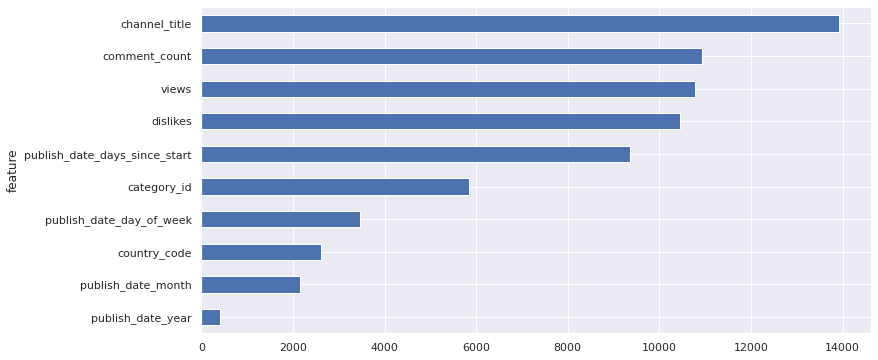

In [92]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [93]:
df['channel_title_num_videos'] = df['channel_title'].map(df['channel_title'].value_counts())
df['publish_date_num_videos'] = df['publish_date'].map(df['publish_date'].value_counts())

In [94]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]

In [95]:
cat_num_cols

['channel_title',
 'category_id',
 'views',
 'dislikes',
 'comment_count',
 'country_code',
 'publish_date_days_since_start',
 'publish_date_day_of_week',
 'publish_date_year',
 'publish_date_month',
 'channel_title_num_videos',
 'publish_date_num_videos']


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.606433
[600]	valid_0's rmse: 0.582532
[900]	valid_0's rmse: 0.570429
[1200]	valid_0's rmse: 0.564703
[1500]	valid_0's rmse: 0.560397
[1800]	valid_0's rmse: 0.558502
[2100]	valid_0's rmse: 0.557166
[2400]	valid_0's rmse: 0.556729
[2700]	valid_0's rmse: 0.555346
[3000]	valid_0's rmse: 0.554132
Did not meet early stopping. Best iteration is:
[2997]	valid_0's rmse: 0.554111

AV metric score for validation set is 554.1113656002269

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.613426
[600]	valid_0's rmse: 0.589525
[900]	valid_0's rmse: 0.578287
[1200]	valid_0's rmse: 0.572217
[1500]	valid_0's rmse: 0.568607
[1800]	valid_0's rmse: 0.566672
[2100]	valid_0's rmse: 0.564948
[2400]	valid_0's rmse: 0.563426
[2700]	valid_0's rmse: 0.561754
Early stopping, best iteration is:
[2782]	valid_0's rmse: 0.561

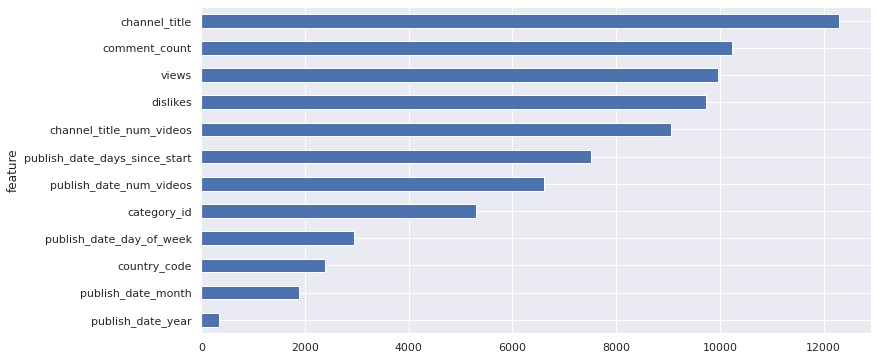

In [96]:
clf = LGBMRegressor(n_estimators = 3000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [97]:
df['channel_in_n_countries'] = df.groupby('channel_title')['country_code'].transform('nunique')

In [98]:
df['channel_in_n_countries'].unique()

array([2, 1, 3, 4])

In [99]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.602211
[600]	valid_0's rmse: 0.576537
[900]	valid_0's rmse: 0.564352
[1200]	valid_0's rmse: 0.557464
[1500]	valid_0's rmse: 0.553461
[1800]	valid_0's rmse: 0.550827
[2100]	valid_0's rmse: 0.549391
[2400]	valid_0's rmse: 0.548714
[2700]	valid_0's rmse: 0.547864
[3000]	valid_0's rmse: 0.547396
Did not meet early stopping. Best iteration is:
[2944]	valid_0's rmse: 0.54724

AV metric score for validation set is 547.2401950313833

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.606165
[600]	valid_0's rmse: 0.584343
[900]	valid_0's rmse: 0.574279
[1200]	valid_0's rmse: 0.567945
[1500]	valid_0's rmse: 0.563975
[1800]	valid_0's rmse: 0.561168
[2100]	valid_0's rmse: 0.559567
[2400]	valid_0's rmse: 0.557947
[2700]	valid_0's rmse: 0.557585
Early stopping, best iteration is:
[2535]	valid_0's rmse: 0.5575

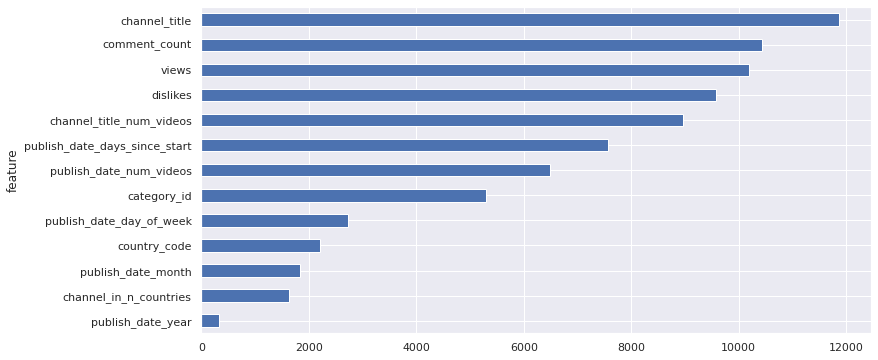

In [100]:
clf = LGBMRegressor(n_estimators = 3000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [101]:
df.columns

Index(['video_id', 'title', 'channel_title', 'category_id', 'publish_date',
       'tags', 'views', 'dislikes', 'comment_count', 'description',
       'country_code', 'likes', 'publish_date_days_since_start',
       'publish_date_day_of_week', 'publish_date_year', 'publish_date_month',
       'channel_title_num_videos', 'publish_date_num_videos',
       'channel_in_n_countries'],
      dtype='object')

In [102]:
df['channel_title_median_views'] = df.groupby('channel_title')['views'].transform('median')
df['channel_title_max_views'] = df.groupby('channel_title')['views'].transform('max')
df['channel_title_min_views'] = df.groupby('channel_title')['views'].transform('min')

df['channel_title_median_comments'] = df.groupby('channel_title')['comment_count'].transform('median')
df['channel_title_max_comments'] = df.groupby('channel_title')['comment_count'].transform('max')
df['channel_title_min_comments'] = df.groupby('channel_title')['comment_count'].transform('min')

df['channel_title_median_dislikes'] = df.groupby('channel_title')['dislikes'].transform('median')
df['channel_title_max_dislikes'] = df.groupby('channel_title')['dislikes'].transform('max')
df['channel_title_min_dislikes'] = df.groupby('channel_title')['dislikes'].transform('min')




In [103]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.550979
[600]	valid_0's rmse: 0.523735
[900]	valid_0's rmse: 0.513453
[1200]	valid_0's rmse: 0.508178
[1500]	valid_0's rmse: 0.503205
[1800]	valid_0's rmse: 0.501708
[2100]	valid_0's rmse: 0.50039
[2400]	valid_0's rmse: 0.499047
[2700]	valid_0's rmse: 0.498785
Early stopping, best iteration is:
[2583]	valid_0's rmse: 0.498393

AV metric score for validation set is 498.39268780810767

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.544795
[600]	valid_0's rmse: 0.521641
[900]	valid_0's rmse: 0.510854
[1200]	valid_0's rmse: 0.505281
[1500]	valid_0's rmse: 0.501583
[1800]	valid_0's rmse: 0.499666
[2100]	valid_0's rmse: 0.498024
[2400]	valid_0's rmse: 0.497137
[2700]	valid_0's rmse: 0.495915
Early stopping, best iteration is:
[2798]	valid_0's rmse: 0.49543

AV metric score for validation set is 495

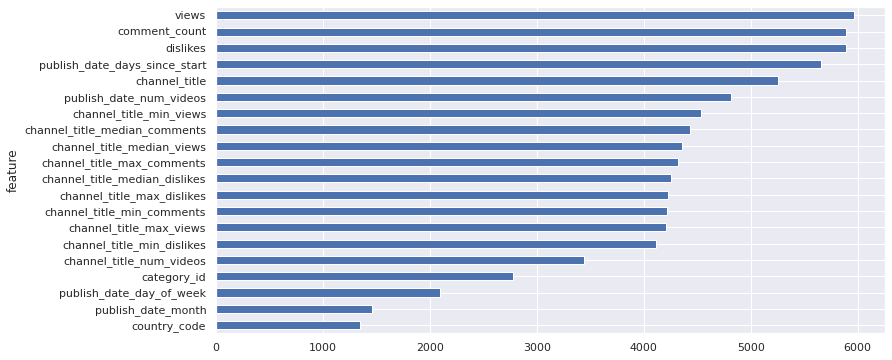

In [104]:
clf = LGBMRegressor(n_estimators = 3000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_fe_num_cat.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [105]:
df['title_len'] = df['title'].apply(lambda x: len(x))
df['description_len'] = df['description'].apply(lambda x: len(x))
df['tags_len'] = df['tags'].apply(lambda x: len(x))

In [106]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.542474
[600]	valid_0's rmse: 0.51495
[900]	valid_0's rmse: 0.503364
[1200]	valid_0's rmse: 0.497404
[1500]	valid_0's rmse: 0.493628
[1800]	valid_0's rmse: 0.491352
[2100]	valid_0's rmse: 0.489441
[2400]	valid_0's rmse: 0.487879
[2700]	valid_0's rmse: 0.486786
[3000]	valid_0's rmse: 0.486323
Did not meet early stopping. Best iteration is:
[2978]	valid_0's rmse: 0.486223

AV metric score for validation set is 486.22330639798156

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.539722
[600]	valid_0's rmse: 0.514769
[900]	valid_0's rmse: 0.501437
[1200]	valid_0's rmse: 0.495133
[1500]	valid_0's rmse: 0.491657
[1800]	valid_0's rmse: 0.489565
[2100]	valid_0's rmse: 0.487519
[2400]	valid_0's rmse: 0.485991
[2700]	valid_0's rmse: 0.48517
[3000]	valid_0's rmse: 0.484839
Did not meet early stopping. Bes

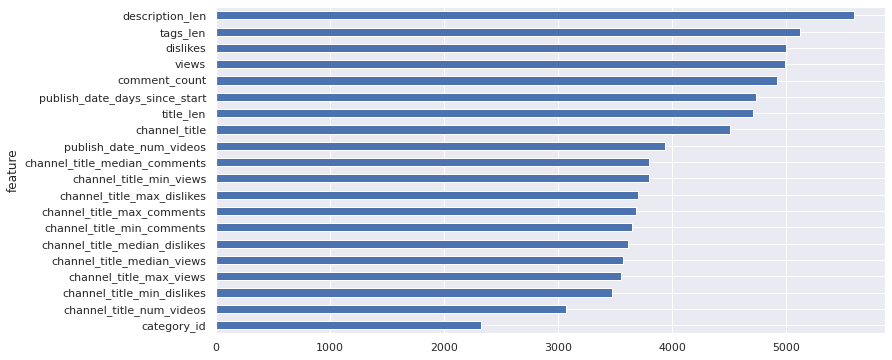

In [107]:
clf = LGBMRegressor(n_estimators = 3000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_text_cols_len.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [105]:
df

video_id  ... tags_len
0         53364  ...      187
1         51040  ...      494
2          1856  ...      143
3         22618  ...       80
4         74074  ...      290
...         ...  ...      ...
37226     19415  ...      495
37227     25168  ...      176
37228     80293  ...      360
37229     80880  ...      320
37230      6514  ...       93

[37231 rows x 31 columns]

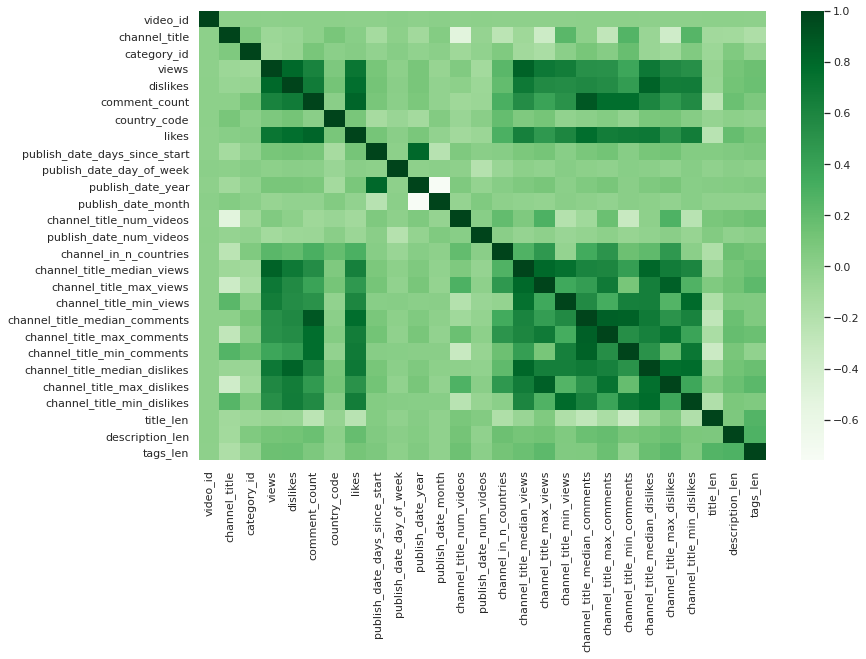

In [106]:
_ = sns.heatmap(df.corr(),cmap='Greens')

In [116]:
from sklearn.feature_extraction.text import CountVectorizer


In [117]:
TOP_N_WORDS = 750

vec = CountVectorizer(max_features = TOP_N_WORDS)
txt_to_ft1 = vec.fit_transform(df['description']).toarray()
txt_to_ft2 = vec.fit_transform(df['tags']).toarray()
txt_to_ft3 = vec.fit_transform(df['title']).toarray()

In [128]:
df.head(3)

video_id  ... title_word_49_count
0     53364  ...                   0
1     51040  ...                   0
2      1856  ...                   0

[3 rows x 181 columns]

In [118]:
e = 'description'
txt_fts_name1 = [e + f'_word_{i}_count' for i in range(TOP_N_WORDS)]
df[txt_fts_name1] = txt_to_ft1

a = 'tags'
txt_fts_name2 = [a + f'_word_{i}_count' for i in range(TOP_N_WORDS)]
df[txt_fts_name2] = txt_to_ft2

z = 'title'
txt_fts_name3 = [z + f'_word_{i}_count' for i in range(TOP_N_WORDS)]
df[txt_fts_name3] = txt_to_ft3

train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['tags','title','description','publish_date']]


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[400]	valid_0's rmse: 0.508087
[800]	valid_0's rmse: 0.489926
[1200]	valid_0's rmse: 0.481093
[1600]	valid_0's rmse: 0.477014
[2000]	valid_0's rmse: 0.473677
[2400]	valid_0's rmse: 0.471143
Did not meet early stopping. Best iteration is:
[2500]	valid_0's rmse: 0.470625

AV metric score for validation set is 470.6251740857374

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[400]	valid_0's rmse: 0.50118
[800]	valid_0's rmse: 0.484784
[1200]	valid_0's rmse: 0.477462
[1600]	valid_0's rmse: 0.473913
[2000]	valid_0's rmse: 0.471199
[2400]	valid_0's rmse: 0.469144
Did not meet early stopping. Best iteration is:
[2497]	valid_0's rmse: 0.468674

AV metric score for validation set is 468.67404039322673

------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds.
[400]	valid_0's rmse: 0.492333
[800]	valid_0's rm

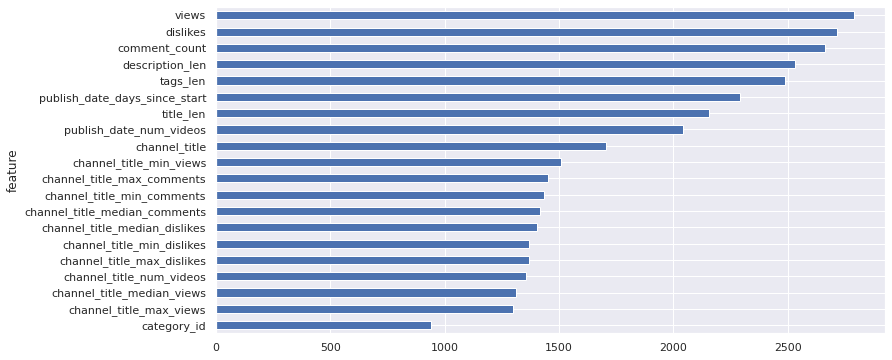

In [122]:
clf = LGBMRegressor(n_estimators = 2500,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 400, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [123]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_final4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [126]:
train_new = train[[ID_COL, TARGET_COL]]
train_new[TARGET_COL] = np.log1p(train_new[TARGET_COL])

test_new = test[[ID_COL]]

train_new['lgb'] = lgb_oofs
test_new['lgb'] = lgb_preds

train_new['cb'] = cb_oofs
test_new['cb'] = cb_preds

train_new['xgb'] = xgb_oofs
test_new['xgb'] = xgb_preds

features = [c for c in train_new.columns if c not in [ID_COL, TARGET_COL]]

In [127]:

clf = ElasticNet(alpha=0,random_state=2)

ens_oofs, ens_preds = run_clf_kfold(clf, train_new, test_new, features)


------------- Fold 1 -------------

AV metric score for validation set is 470.05316574047276

------------- Fold 2 -------------

AV metric score for validation set is 467.53086450962974

------------- Fold 3 -------------

AV metric score for validation set is 460.68787073047076

------------- Fold 4 -------------

AV metric score for validation set is 451.995568477059

------------- Fold 5 -------------

AV metric score for validation set is 456.3886419933777


AV metric for oofs is 461.3806537889325


In [128]:
ens_preds_t = np.expm1(ens_preds)
download_preds(ens_preds_t, file_name = 'hacklive_final4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>